# Mental Health Analysis

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
%reload_ext autoreload

import pandas as pd
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from sklearn.model_selection import train_test_split

from mentalhealth.data_cleaning import load_and_combine_dataset, label_mental_health_subreddits
from mentalhealth.data_cleaning import clean_text

from mentalhealth.data_preprocessing import parallel_text_statistics
from mentalhealth.data_preprocessing import tokenize_and_parallelize

from mentalhealth.data_visualization import plot_post_counts_by_subreddit
from mentalhealth.data_visualization import plot_post_lengths_by_target
from mentalhealth.data_visualization import generate_wordcloud

from mentalhealth.model_training_testing import train_and_evaluate_model
from mentalhealth.model_training_testing import extract_tfidf_features

from mentalhealth.model_training_testing import display_performance_metrics

## Data Cleaning

In [2]:
data_folder = "reddit_mental_health_data"
mental_health_df = load_and_combine_dataset(data_folder)
mental_health_df, subreddits_df = label_mental_health_subreddits(mental_health_df)
mental_health_df.head()

subreddit              author        date  \
0      guns        TrickyWidget  2019/08/29   
1      guns            Phonkboi  2019/08/29   
2      guns         civildallas  2019/08/29   
3      guns            alphenos  2019/08/29   
4      guns  ThePrince_OfWhales  2019/08/29   

                                                post             target  
0  Bersa Thunder 22: Long-term reliability? Hi, f...  non_mental_health  
1  Anybody have any experience with the diamondba...  non_mental_health  
2  Old &amp; New // Colt 1911 &amp; MCX Rattler I...  non_mental_health  
3  Start working in a gun shop next week. Need so...  non_mental_health  
4  Cheap targets for plinking? I'm headed to the ...  non_mental_health

In [3]:
mental_health_df['target'].unique()

array(['non_mental_health', 'socialanxiety', 'adhd', 'autism', 'ptsd',
       'suicidewatch', 'lonely', 'mentalhealth', 'alcoholism',
       'bipolarreddit', 'schizophrenia', 'depression', 'EDAnonymous',
       'addiction', 'healthanxiety', 'COVID19_support', 'anxiety', 'bpd'],
      dtype=object)

In [4]:
mental_health_df.shape

(1107302, 5)

# Removing Non-string Characters

In [5]:
mental_health_df['cleaned_post'] = mental_health_df['post'].apply(lambda x: clean_text(str(x)))
mental_health_df.head()

subreddit              author        date  \
0      guns        TrickyWidget  2019/08/29   
1      guns            Phonkboi  2019/08/29   
2      guns         civildallas  2019/08/29   
3      guns            alphenos  2019/08/29   
4      guns  ThePrince_OfWhales  2019/08/29   

                                                post             target  \
0  Bersa Thunder 22: Long-term reliability? Hi, f...  non_mental_health   
1  Anybody have any experience with the diamondba...  non_mental_health   
2  Old &amp; New // Colt 1911 &amp; MCX Rattler I...  non_mental_health   
3  Start working in a gun shop next week. Need so...  non_mental_health   
4  Cheap targets for plinking? I'm headed to the ...  non_mental_health   

                                        cleaned_post  
0  Bersa Thunder 22: Long-term reliability? Hi, f...  
1  Anybody have any experience with the diamondba...  
2  Old & New // Colt 1911 & MCX Rattler If y'all ...  
3  Start working in a gun shop next week. Need so...  
4  Cheap targets for plinking? I'm headed to the ...

### DATA SET CREATION AND EMPIRICAL ANALYSIS FOR DETECTING SIGNS OF DEPRESSION FROM SOCIAL MEDIA POSTINGS

* Sampath, Kayalvizhi, and Thenmozhi Durairaj. "Data set creation and empirical analysis for detecting signs of depression from social media postings." 
* International Conference on Computational Intelligence in Data Science. Cham: Springer International Publishing, 2022.

* the text and title part are pre-processed by removing the non-ASCII characters and emoticons
* to get a clean data set

In [6]:
mental_health_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107302 entries, 0 to 1107301
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   subreddit     1107302 non-null  object
 1   author        1107302 non-null  object
 2   date          1107302 non-null  object
 3   post          1107302 non-null  object
 4   target        1107302 non-null  object
 5   cleaned_post  1107302 non-null  object
dtypes: object(6)
memory usage: 50.7+ MB


In [7]:
mental_health_df.describe()

subreddit     author        date  \
count       1107302    1107302     1107302   
unique           28     826961         587   
top     legaladvice  [deleted]  2019/01/03   
freq         164233         41        5186   

                                                     post             target  \
count                                             1107302            1107302   
unique                                            1024141                 18   
top     Why did the chicken cross the road? To get to ...  non_mental_health   
freq                                                   14             634489   

                                             cleaned_post  
count                                             1107302  
unique                                            1024131  
top     Why did the chicken cross the road? To get to ...  
freq                                                   14

In [8]:
mental_health_df.isnull().sum()

subreddit       0
author          0
date            0
post            0
target          0
cleaned_post    0
dtype: int64

In [9]:
mental_health_df.target.value_counts()

target
non_mental_health    634489
depression           117331
suicidewatch          66161
anxiety               57671
adhd                  45631
mentalhealth          45332
bpd                   24294
lonely                23635
socialanxiety         22996
EDAnonymous           14577
autism                 8869
schizophrenia          8712
healthanxiety          8648
ptsd                   8643
addiction              7641
alcoholism             5911
bipolarreddit          5780
COVID19_support         981
Name: count, dtype: int64

## Formatting Date

In [10]:
mental_health_df['date'] = pd.to_datetime(mental_health_df['date'])
mental_health_df['year'] = mental_health_df['date'].dt.year
mental_health_df['month'] = mental_health_df['date'].dt.month
mental_health_df['day'] = mental_health_df['date'].dt.day
mental_health_df.head()

subreddit              author       date  \
0      guns        TrickyWidget 2019-08-29   
1      guns            Phonkboi 2019-08-29   
2      guns         civildallas 2019-08-29   
3      guns            alphenos 2019-08-29   
4      guns  ThePrince_OfWhales 2019-08-29   

                                                post             target  \
0  Bersa Thunder 22: Long-term reliability? Hi, f...  non_mental_health   
1  Anybody have any experience with the diamondba...  non_mental_health   
2  Old &amp; New // Colt 1911 &amp; MCX Rattler I...  non_mental_health   
3  Start working in a gun shop next week. Need so...  non_mental_health   
4  Cheap targets for plinking? I'm headed to the ...  non_mental_health   

                                        cleaned_post  year  month  day  
0  Bersa Thunder 22: Long-term reliability? Hi, f...  2019      8   29  
1  Anybody have any experience with the diamondba...  2019      8   29  
2  Old & New // Colt 1911 & MCX Rattler If y'all ...  2019      8   29  
3  Start working in a gun shop next week. Need so...  2019      8   29  
4  Cheap targets for plinking? I'm headed to the ...  2019      8   29

## Text Statistics

In [11]:
%%time
stats_core_8 = parallel_text_statistics(mental_health_df, 'cleaned_post', num_cores=8)
print(stats_core_8)

{'total_words': 198807402, 'unique_words_count': 239494, 'total_sentences': 12742645, 'total_words_without_stopwords': 77943241}
CPU times: user 1.56 s, sys: 2.81 s, total: 4.37 s
Wall time: 2h 17min 4s


In [12]:
print(f"Total Words: {stats_core_8['total_words']}")
print(f"Unique Words: {stats_core_8['unique_words_count']}")
print(f"Total Sentences: {stats_core_8['total_sentences']}")
print(f"Total Words without Stopwords: {stats_core_8['total_words_without_stopwords']}")

Total Words: 198807402
Unique Words: 239494
Total Sentences: 12742645
Total Words without Stopwords: 77943241


In [13]:
df = pd.DataFrame(list(stats_core_8.items()), columns=["Metric", "Value"])

# Save DataFrame as CSV
df.to_csv("stats_core_8.csv", index=False)

## EDA

## Distribution of tweets across different target variables

In [2]:
mental_health_df = pd.read_csv('mental_health_data.csv')

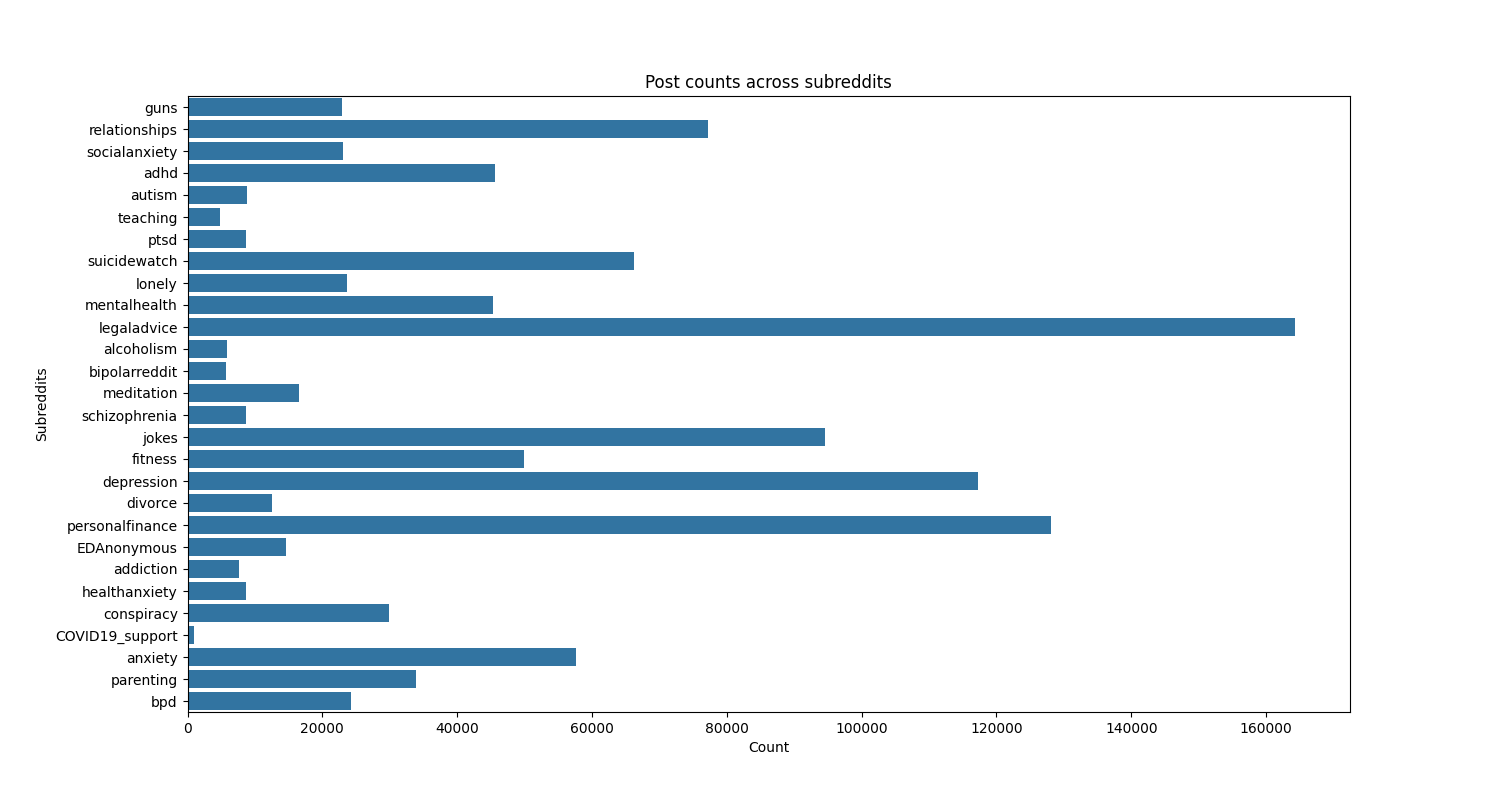

In [4]:
plot_post_counts_by_subreddit(mental_health_df)

## Relation between post length and mental health

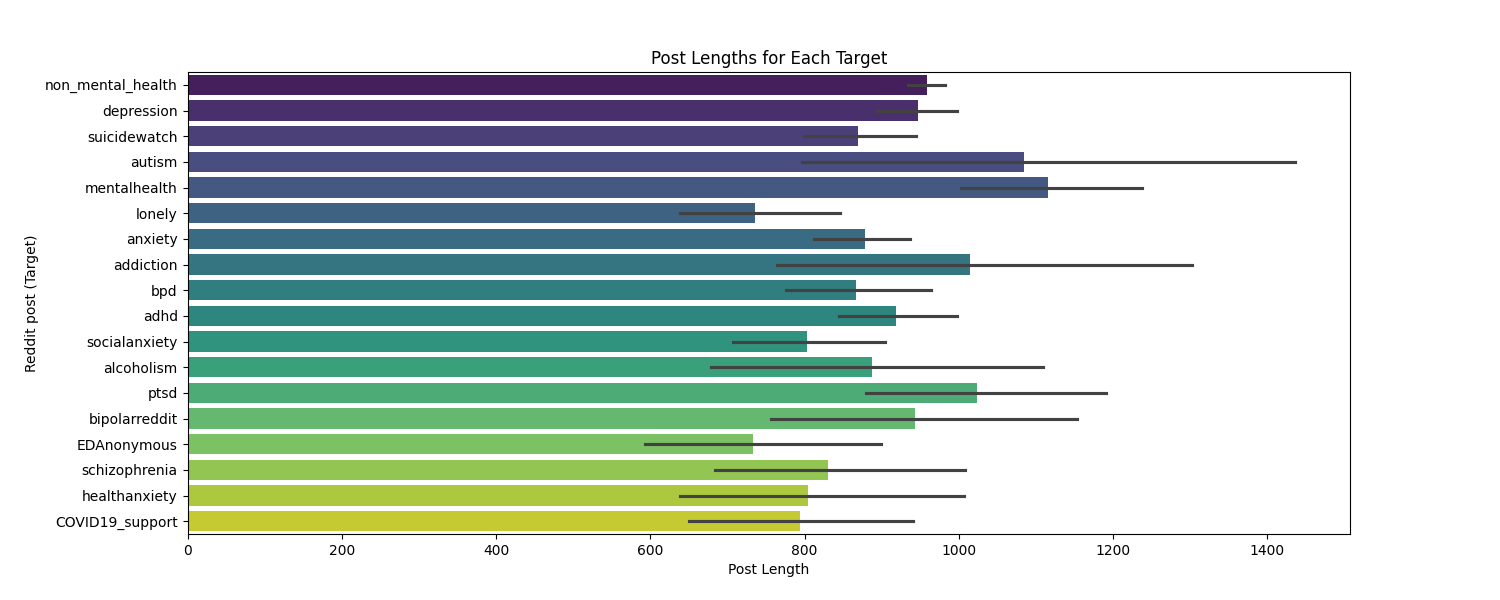

In [5]:
mental_health_df['post_length'] = mental_health_df['cleaned_post'].str.len()
sampled_data = mental_health_df.sample(n=10000, random_state=42)

plot_post_lengths_by_target(sampled_data)

## Word Clouds

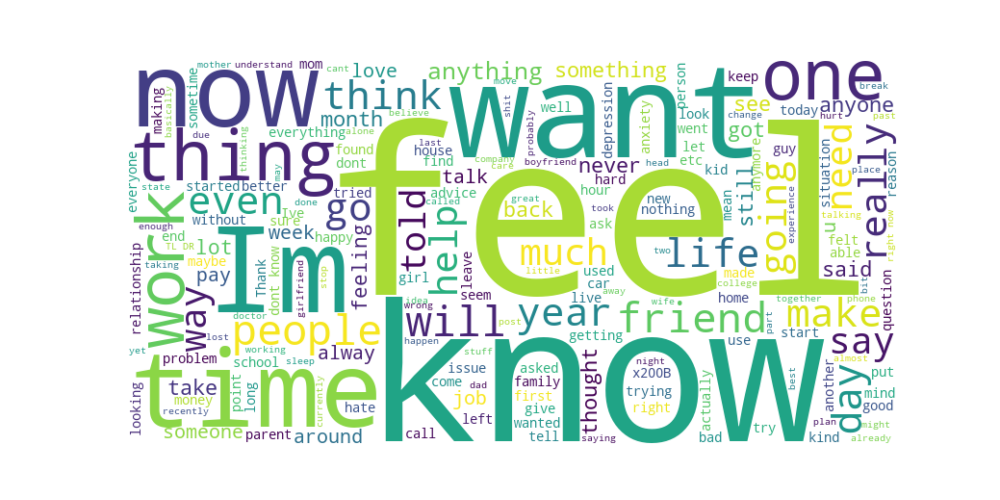

In [6]:
wordcloud_sample_data = mental_health_df.sample(n=10000, random_state=42)
generate_wordcloud(wordcloud_sample_data,'cleaned_post')

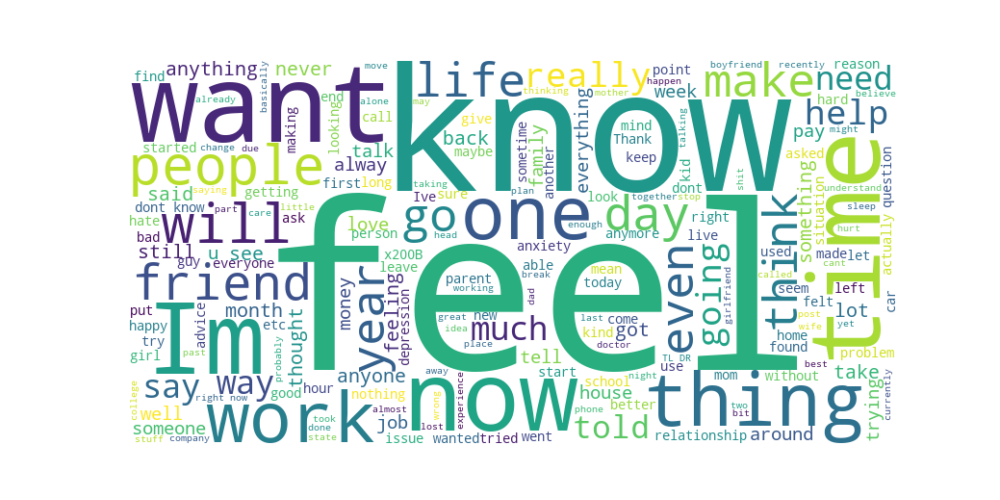

In [7]:
wordcloud_sample_data_1 = mental_health_df.sample(n=100000, random_state=42)
generate_wordcloud(wordcloud_sample_data,'cleaned_post')

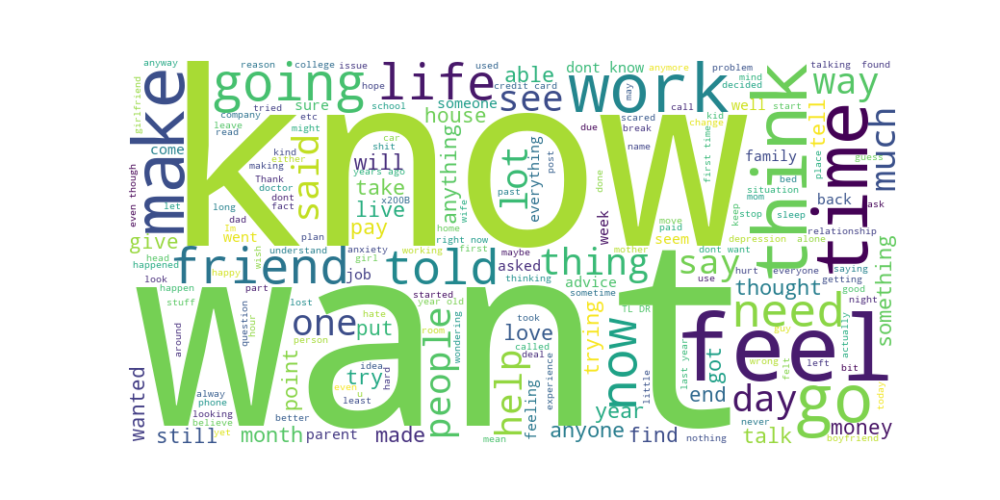

CPU times: user 4min 39s, sys: 2min 21s, total: 7min 1s
Wall time: 8min 9s


In [3]:
%%time
generate_wordcloud(mental_health_df,'cleaned_post')

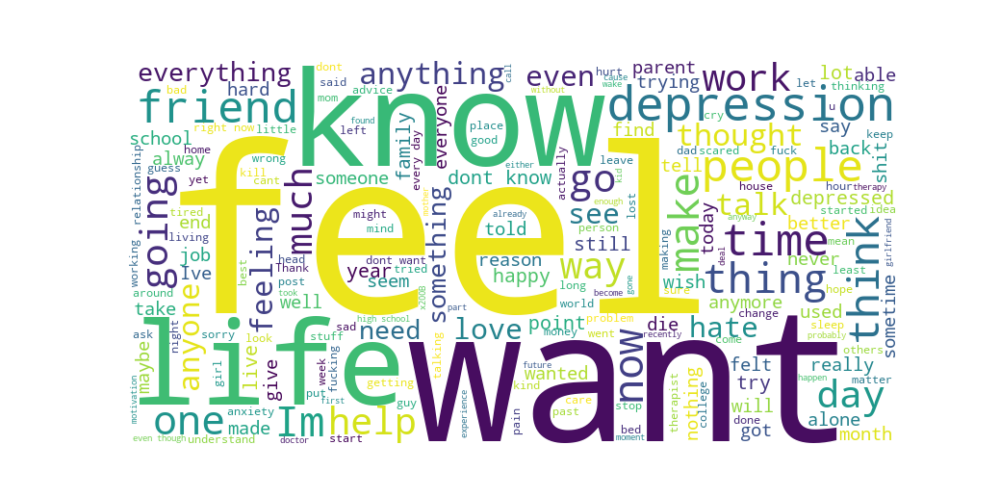

CPU times: user 27.2 s, sys: 867 ms, total: 28.1 s
Wall time: 29 s


In [4]:
%%time
generate_wordcloud(mental_health_df[mental_health_df.target == 'depression'],'cleaned_post')

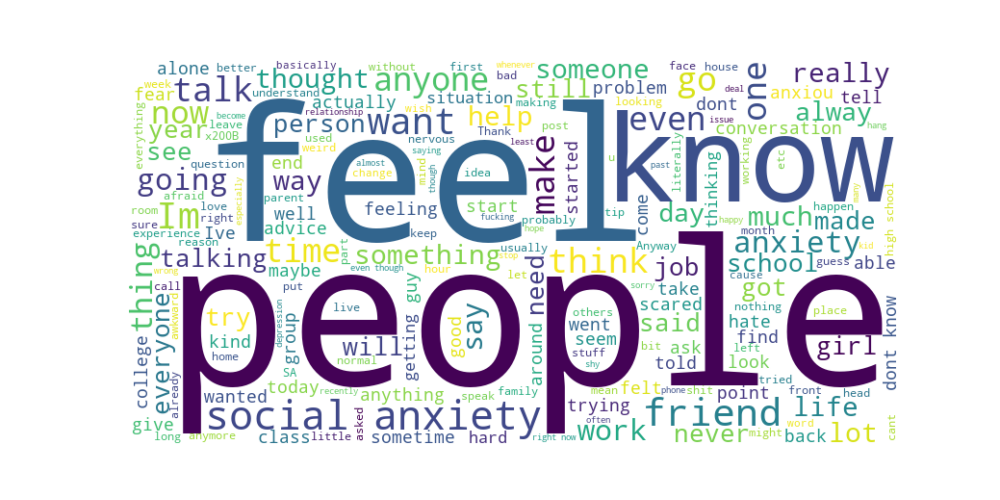

CPU times: user 5.22 s, sys: 228 ms, total: 5.45 s
Wall time: 5.68 s


In [5]:
%%time
generate_wordcloud(mental_health_df[mental_health_df.target == 'socialanxiety'],'cleaned_post')

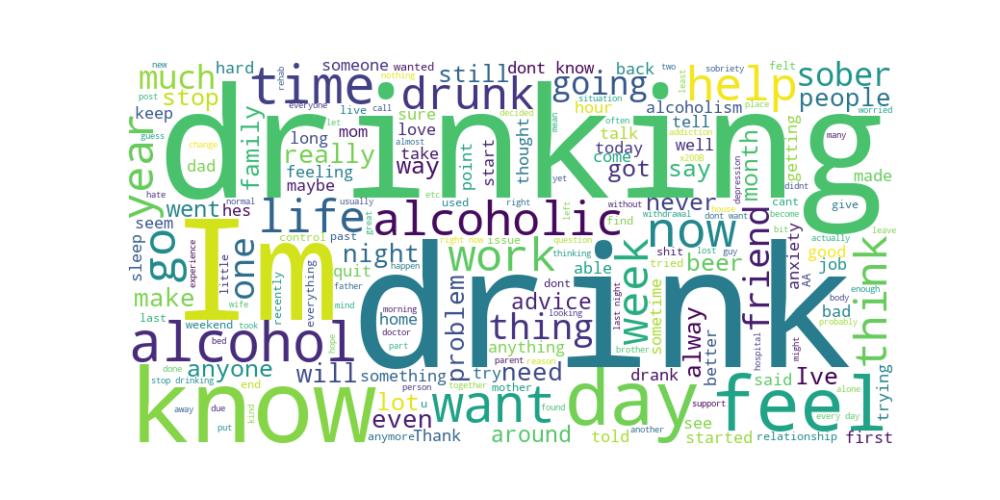

CPU times: user 1.86 s, sys: 98.9 ms, total: 1.96 s
Wall time: 2.09 s


In [6]:
%%time
generate_wordcloud(mental_health_df[mental_health_df.target == 'alcoholism'],'cleaned_post')

In [ ]:
mental_health_df.to_csv('mental_health_data.csv', index=False)

### Spacy Blog Reference

> https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

####  Text -> Feature Extraction -> Features -> Machine Learning Algorithm -> Text classification

## Token Stream

- Storing tokens as in Parquet Format

In [ ]:
%%time
train_data, test_data = train_test_split(mental_health_df, test_size=0.2, random_state=42, stratify=mental_health_df.target)
tokenize_and_parallelize(train_data, 'tokenized_and_lemmatized_train_data.parquet')

tokenize_and_parallelize(test_data, 'tokenized_and_lemmatized_test_data.parquet')

/Users/keshavelango/Documents/GitHub/capstone/Mental-Health-Analysis-using-Social-Media-Data/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/keshavelango/Documents/GitHub/capstone/Mental-Health-Analysis-using-Social-Media-Data/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


CPU times: user 18 s, sys: 12.7 s, total: 30.7 s
Wall time: 1h 40min 31s


In [ ]:
%%time
mental_health_train_df = pd.read_parquet('tokenized_and_lemmatized_train_data.parquet')
mental_health_train_df.head()

CPU times: user 4.76 s, sys: 966 ms, total: 5.73 s
Wall time: 5.91 s


lemmatized_tokens             target
0  [feel, bad, feel, bad, amazing, month, 2019, h...            anxiety
1  [Harvey, Weinstein, reptilian, weird, stuff, i...  non_mental_health
2  [housing, bankrupt, law, wife, consider, idea,...  non_mental_health
3  [feel, trap, 23, year, old, male, not, go, col...       suicidewatch
4  [want, black, panther, theatre, want, way, hon...  non_mental_health

In [ ]:
%%time
mental_health_test_df = pd.read_parquet('tokenized_and_lemmatized_test_data.parquet')
mental_health_test_df.head()

CPU times: user 1.05 s, sys: 124 ms, total: 1.18 s
Wall time: 1.2 s


lemmatized_tokens             target
0  [money, leftover, bill, okay, deal, move, stud...  non_mental_health
1  [need, want, need, guy, ik, absolutely, depend...         depression
2  [MIL, overrule, parenting, technique, point, g...  non_mental_health
3  [dae, mimic, body, language, book, read, mimic...             autism
4  [Existential, Thoughts, race, mind, acknowledg...               adhd

In [2]:
mental_health_train_df = pd.read_parquet('tokenized_and_lemmatized_train_data.parquet')
mental_health_test_df = pd.read_parquet('tokenized_and_lemmatized_test_data.parquet')

X_train = mental_health_train_df['lemmatized_tokens']
y_train = mental_health_train_df['target']

X_test = mental_health_test_df['lemmatized_tokens']
y_test = mental_health_test_df['target']

In [ ]:
mental_health_test_df['lemmatized_tokens']

0         [money, leftover, bill, okay, deal, move, stud...
1         [need, want, need, guy, ik, absolutely, depend...
2         [MIL, overrule, parenting, technique, point, g...
3         [dae, mimic, body, language, book, read, mimic...
4         [Existential, Thoughts, race, mind, acknowledg...
                                ...                        
221456    [lose, need, talk, lose, job, today, nurse, ge...
221457    [question, 401k, finally, land, time, job, m, ...
221458    [f55, feel, unappreciated, neglect, F55, hope,...
221459    [family, member, let, old, job, wrongful, accu...
221460    [employer, /w, employee, Anxiety, seek, advice...
Name: lemmatized_tokens, Length: 221461, dtype: object

In [ ]:
%%time
y_test_logistic, y_pred_logistic, model_name_logistic = train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type='logistic')

inside save_model
Model saved as ONNX at logistic_mental_health.onnx
CPU times: user 4min 35s, sys: 9.86 s, total: 4min 45s
Wall time: 4min 45s


In [4]:
%%time
metrics_logistic = display_performance_metrics(y_test_logistic, y_pred_logistic, model_name_logistic)

inside performance metrics
Model: Logistic Regression
Accuracy: 0.8081
Precision: 0.7988
Recall: 0.8081
F1 Score: 0.8002
Classification Report:
                   precision    recall  f1-score   support

  COVID19_support       0.51      0.16      0.25       196
      EDAnonymous       0.82      0.68      0.75      2916
        addiction       0.73      0.61      0.66      1528
             adhd       0.84      0.79      0.81      9126
       alcoholism       0.75      0.66      0.70      1182
          anxiety       0.67      0.65      0.66     11534
           autism       0.84      0.59      0.70      1774
    bipolarreddit       0.65      0.37      0.47      1156
              bpd       0.80      0.58      0.67      4859
       depression       0.56      0.64      0.60     23466
    healthanxiety       0.73      0.53      0.61      1730
           lonely       0.59      0.48      0.53      4727
     mentalhealth       0.45      0.30      0.36      9067
non_mental_health       0.91 

In [13]:
%%time
y_test_nb, y_pred_nb, model_name_nb = train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type='nb')

Model saved as ONNX at nb_mental_health.onnx
CPU times: user 1min 13s, sys: 2.3 s, total: 1min 15s
Wall time: 1min 16s


In [14]:
%%time
metrics_nb = display_performance_metrics(y_test_nb, y_pred_nb, model_name_nb)

Model: Naive Bayes
Accuracy: 0.7363
Precision: 0.7344
Recall: 0.7363
F1 Score: 0.7121
Classification Report:
                   precision    recall  f1-score   support

  COVID19_support       0.00      0.00      0.00       196
      EDAnonymous       0.69      0.53      0.60      2916
        addiction       0.73      0.30      0.43      1528
             adhd       0.78      0.62      0.69      9126
       alcoholism       0.79      0.37      0.50      1182
          anxiety       0.58      0.46      0.51     11534
           autism       0.86      0.32      0.47      1774
    bipolarreddit       0.62      0.16      0.25      1156
              bpd       0.82      0.36      0.50      4859
       depression       0.42      0.70      0.52     23466
    healthanxiety       0.65      0.39      0.49      1730
           lonely       0.56      0.20      0.30      4727
     mentalhealth       0.37      0.14      0.20      9067
non_mental_health       0.85      0.96      0.90    126898
     

In [11]:
%%time
y_test_lgbm, y_pred_lgbm, model_name_lgbm = train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type='lgbm')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.186111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 827999
[LightGBM] [Info] Number of data points in the train set: 885841, number of used features: 5000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/Users/keshavelango/Documents/GitHub/capstone/Mental-Health-Analysis-using-Social-Media-Data/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CPU times: user 10min 19s, sys: 1min 21s, total: 11min 41s
Wall time: 2min 23s


In [12]:
%%time
metrics_lgbm = display_performance_metrics(y_test_lgbm, y_pred_lgbm, model_name_lgbm)

Model: LightGBM
Accuracy: 0.7747
Precision: 0.7570
Recall: 0.7747
F1 Score: 0.7555
Classification Report:
                   precision    recall  f1-score   support

  COVID19_support       0.35      0.08      0.13       196
      EDAnonymous       0.85      0.55      0.67      2916
        addiction       0.71      0.53      0.61      1528
             adhd       0.87      0.68      0.77      9126
       alcoholism       0.72      0.59      0.65      1182
          anxiety       0.64      0.63      0.64     11534
           autism       0.79      0.63      0.70      1774
    bipolarreddit       0.61      0.36      0.45      1156
              bpd       0.85      0.55      0.67      4859
       depression       0.55      0.56      0.55     23466
    healthanxiety       0.73      0.31      0.44      1730
           lonely       0.58      0.37      0.45      4727
     mentalhealth       0.50      0.17      0.26      9067
non_mental_health       0.85      0.98      0.91    126898
        

In [15]:
%%time 
y_test_xgb, y_pred_xgb, model_name_xgb = train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type='xgb')

/Users/keshavelango/Documents/GitHub/capstone/Mental-Health-Analysis-using-Social-Media-Data/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:35:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model saved as ONNX at xgb_mental_health.onnx
CPU times: user 34min 51s, sys: 25.2 s, total: 35min 17s
Wall time: 7min 46s


In [16]:
%%time
metrics_xgb = display_performance_metrics(y_test_xgb, y_pred_xgb, model_name_xgb)

Model: XGBoost
Accuracy: 0.7989
Precision: 0.7858
Recall: 0.7989
F1 Score: 0.7875
Classification Report:
                   precision    recall  f1-score   support

  COVID19_support       0.39      0.09      0.15       196
      EDAnonymous       0.85      0.67      0.75      2916
        addiction       0.71      0.61      0.66      1528
             adhd       0.87      0.75      0.80      9126
       alcoholism       0.76      0.67      0.71      1182
          anxiety       0.66      0.66      0.66     11534
           autism       0.82      0.66      0.73      1774
    bipolarreddit       0.64      0.43      0.52      1156
              bpd       0.83      0.59      0.69      4859
       depression       0.55      0.60      0.58     23466
    healthanxiety       0.72      0.46      0.56      1730
           lonely       0.58      0.45      0.51      4727
     mentalhealth       0.48      0.25      0.33      9067
non_mental_health       0.89      0.98      0.93    126898
         